<a href="https://colab.research.google.com/github/Gamali-Star1/30DaysOfJava/blob/master/Python_Code_for_Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the required package(s)
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 11.2 MB/s eta 0:00:00


In [2]:
# Importing import libraries
import boto3 # This is boto3 library used to interact  with AWS services
import pandas as pd # We import pandas library for data manipulation and analysis
import matplotlib.pyplot as plt # We import matplotlib for static, animated, and interactive visualization
import seaborn as sns
import logging # This is logging library used to configure and using logging in the scripts
import warnings # This is used to ignore warnings or to control the display of warning messages
from sklearn.metrics import (confusion_matrix, classification_report)

warnings.filterwarnings('ignore') # This is used to ignore all warning and keeping of clean screen


# Configure logging
logging.basicConfig(level=logging.INFO)
logg = logging.getLogger(__name__)

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/rbarrimond/gen-ai-msft/main/courier-service_reviews.csv')
df.head()

,id,review,sentiment
0,1,ExpressWay Logistics' commitment to transparen...,Positive
1,2,The tracking system implemented by ExpressWay ...,Positive
2,3,ExpressWay Logistics is a lifesaver when it co...,Positive
3,4,Expressway Logistics is the worst courier serv...,Negative
4,5,ExpressWay Logistics failed to meet my expecta...,Negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         131 non-null    int64 
 1   review     131 non-null    object
 2   sentiment  131 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.2+ KB


Loaded data columns: Index(['id', 'review', 'sentiment'], dtype='object')
Classification Report:
              precision    recall  f1-score   support

       MIXED       0.00      0.00      0.00         0
    NEGATIVE       0.98      0.84      0.91        63
     NEUTRAL       0.00      0.00      0.00         0
    POSITIVE       1.00      0.87      0.93        68

    accuracy                           0.85       131
   macro avg       0.50      0.43      0.46       131
weighted avg       0.99      0.85      0.92       131

|   id | Text                                                  | Ground Truth Sentiment   | Predicted Sentiment   |
|-----:|:------------------------------------------------------|:-------------------------|:----------------------|
|    1 | ExpressWay Logistics' commitment to transparency g... | POSITIVE                 | POSITIVE              |
|    2 | The tracking system implemented by ExpressWay Logi... | POSITIVE                 | POSITIVE              |
|   

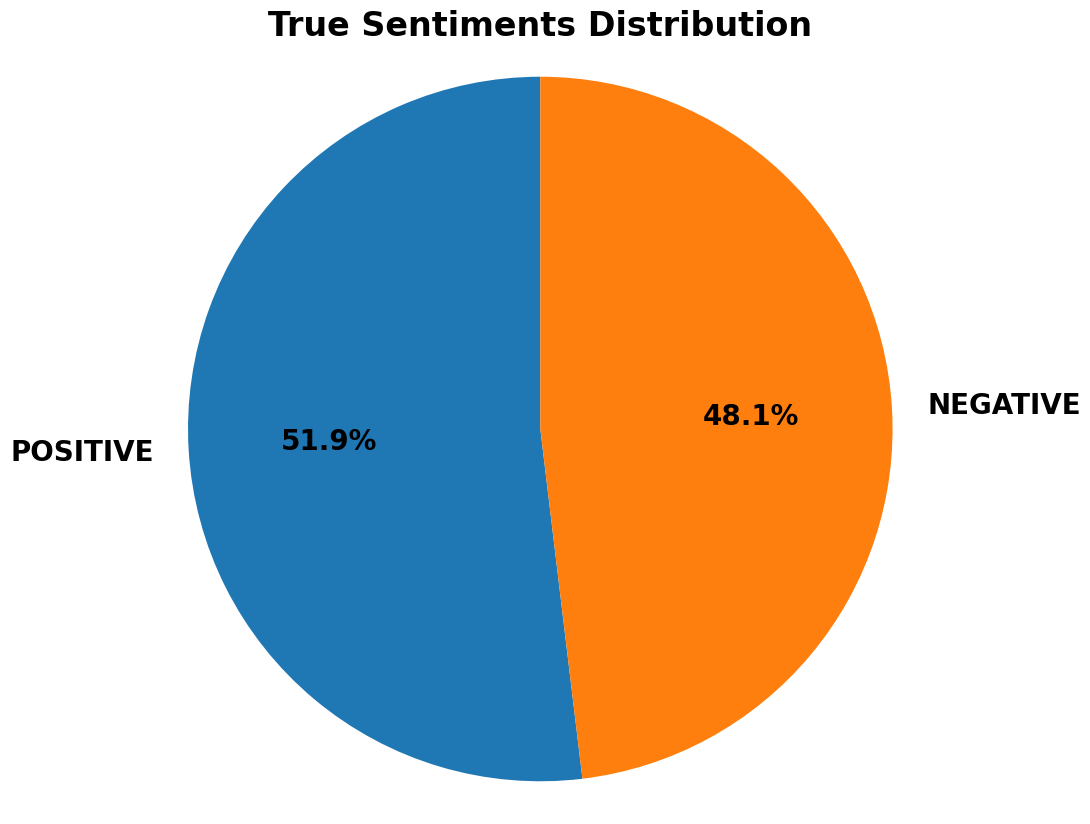

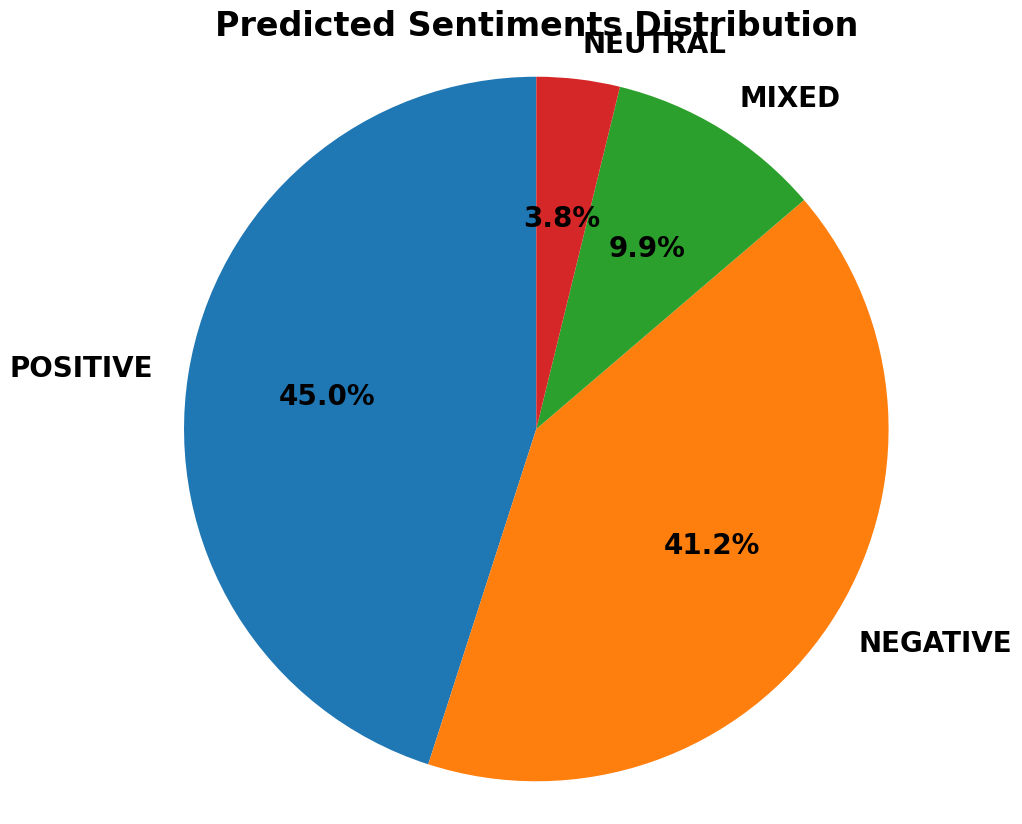

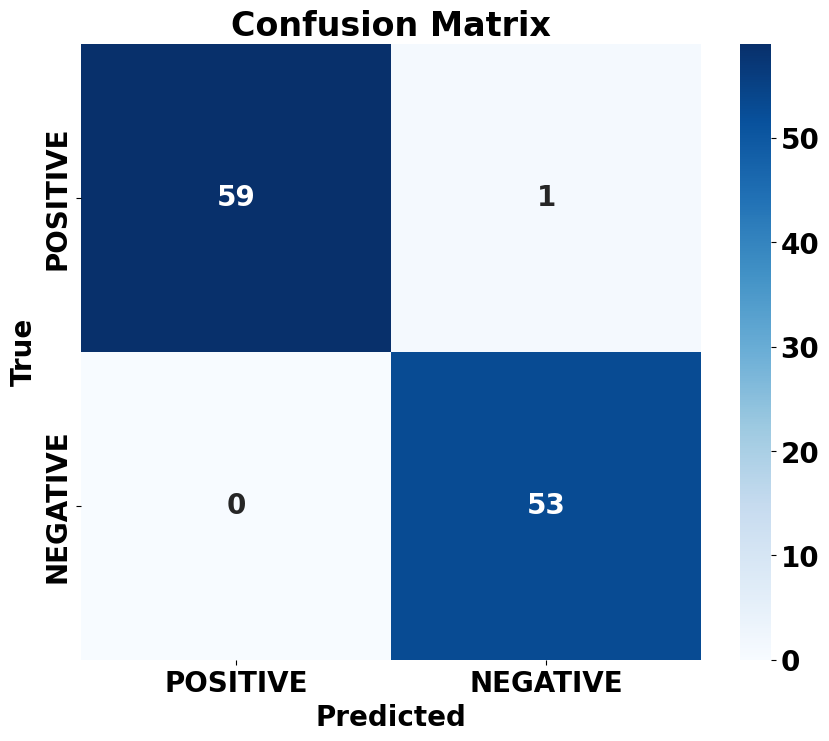

In [13]:

class AWSBedrockSentimentAnalyzer:
    """
    This is a class which used to interact with AWS Bedrock API for sentiment analysis.

    Attributes:
        client (boto3.client): The AWS Bedrock client.
        aws_accessId (str): The AWS credential to get accessId.
        aws_accessKey (str): The AWS credential to get accessKey.
        regionName (str): The AWS region name to be set, an by default it is 'us-east-1'.
    """  # This is a doc string used to explain the purpose and attribute of this class

    def __init__(self, AWSaccessId, AWSaccessKey, regionName="us-east-1"):
        """
        We will design this function to be used to Initialize the AWSBedrockSentimentAnalyzer with the provided AWS credentials.

        Parameters:
            aws_accessId (str): The AWS access key ID.
            aws_accessKey (str): The AWS secret access key.
            region_name (str): The AWS region name.
        """
        self.client = boto3.client(  # Intialize a boto3 client for AWS Comprehend services
            'comprehend',  # Used to specify the AWS service to use (In this case it is AWS Comprehend for sentiment analysis)
            aws_access_key_id=AWSaccessId,  # Used to set AWS access key ID
            aws_secret_access_key=AWSaccessKey,  # Used to set the secret AWS access key
            region_name=regionName  # Used to set the AWS region name (in this case it set 'us-east-1 which is default region setup')
        )

    def sentiment_analysis(self, text):
        """
        Analyzes the sentiment of a given text using AWS Bedrock API.

        Parameters:
            text (str): The text to analyze.

        Returns:
            str: The detected sentiment should be either 'POSITIVE', or 'NEGATIVE'.
        """
        try:
            response = self.client.detect_sentiment(  # Used to call AWS Comprehend functionalities using API in order to detect sentiment in the give text
                Text=text,  # Used to set the text to be analyzed by AWS Comprehend
                LanguageCode='en'  # Used to set the language code for the text (in this case it is English)
            )
            sentiment = response['Sentiment']  # Used to get the sentiment detected by AWS Comprehend using API
            logg.info(f"Text: {text}, Sentiment: {sentiment}")
            return sentiment  # This will return the sentiment detected by AWS Comprehnd
        except Exception as e:  # This is exceptio handling errors which used to handle any exceptions that may occur during the API call
            logg.error(f"Error analyzing text: {text}")
            logg.exception(e)  # This is used to log the exception details
            return None  # This will return None if an exception occurs during the API call

def load_data_from_CSV_file(file_path):
    """
    upload dataset from a CSV file.

    Parameters:
        file_path (str): The path to the CSV file.

    Returns:
        DataFrame: This function is used to lood datasets into pandas DataFrame, or will return None if the file will not be found.
    """
    try:
        df_data = pd.read_csv(file_path, on_bad_lines='skip')
        print(f"Loaded data columns: {df_data.columns}")
        return df_data
    except FileNotFoundError:
        logg.error(f"File not found: {file_path}")
        return None
    except pd.errors.ParserError as e:
        logg.error(f"ParserError: {e}")
        return None

def sentiments_evaluation(model, data):
    """
     This function will Evaluates the sentiments of texts in the dataset using the provided sentiment model.

    Parameters:
        analyzer (AWSBedrockSentimentAnalyzer): The sentiment model instance.
        data (DataFrame): Here, the dataset containing texts and ground truth sentiments.

    Returns:
        DataFrame: A DataFrame containing the id, text, ground truth sentiment, and predicted sentiment.
    """
    output_results = []  # This is used to store the results of the evaluation

    # The following codes will check if the necessary columns are present in dataframe, or if not return epty dataframe
    required_columns = ['review', 'sentiment', 'id']
    for column in required_columns:
        if column not in data.columns:
            logg.error(f"Required column '{column}' is not present in the data.")  # Log an error if a required column is missing.
            return pd.DataFrame(output_results)  # Return an empty DataFrame if any required column is missing.

    for index, row in data.iterrows():  # This is used to iterate over each row in the dataset
        text = row['review']  # This is used to get the text from the current row
        ground_truth_sentiment = row['sentiment'].upper()  # This is used to get the ground truth sentiment from the current row
        id = row['id']  # This is used to get the id from the current row

        # The following codes will analyze sentiment using AWS Bedrock, if they detect they will return dataframe with resuslts
        predicted_sentiment = model.sentiment_analysis(text)

        if predicted_sentiment:  # This is used to check if the predicted sentiment is not None
            output_results.append({  # This is used to append the results to the list
                'id': id,
                'Text': text,
                'Ground Truth Sentiment': ground_truth_sentiment,
                'Predicted Sentiment': predicted_sentiment
            })

    return pd.DataFrame(output_results)  # This will return the DataFrame with the results
    print()
    print() # Leaving of gap between one contents and another

def text_length_minimization(df, textColumn, maxLength=50):
    """
    Minimizes the text length in the DataFrame in the text calumn in orde to fit to allow all columns to fit in output display..

    Parameters:
        df (DataFrame): This is the DataFrame which contains text.
        text_column (str): This is the column which contains the text which are required to be minimize
        max_length (int): This provides the maximum length of text to display.

    Returns:
        DataFrame: The DataFrame with minimized text length.
    """
    texts_shortened = []  # Initialize an empty list to store shortened texts.
    for text in df[textColumn]:  # Iterate over each text in the specified column.
        # Below lines of codes try to check, If the length of the text is greater than the maximum length, truncate it.
        if len(text) > maxLength:
            texts_shortened.append(text[:maxLength] + "...")
        else:
            texts_shortened.append(text)  # If text is within the limit, keep it unchanged.

    df[textColumn] = texts_shortened  # Update the DataFrame column with the shortened texts.
    return df  # Return the updated DataFrame.
    print()
    print() # Leaving of gap between one contents and another

def pie_chart_visualization(sentiments, title):
    """
    This function will be used to Plot a pie chart of sentiments.

    Parameters:
        sentiments (list): List of sentiments.
        title (str): Title of the pie chart.
    """
    sentiment_counts = pd.Series(sentiments).value_counts()  # Used Count the occurrences of each sentiment

    # We want to make font sizes within the graph in this case is pie chart to be  large and bold
    plt.rc("font", size=20, weight="bold")

    # Below are figure, pie, title, axis, ylabel, and show functions which used to plot pie chart visualization
    plt.figure(figsize=(10, 10))
    sentiment_counts.plot.pie(autopct="%1.1f%%", startangle=90)
    plt.setp(plt.gca().texts, fontsize=20, fontweight="bold")

    plt.title(title, fontsize=24, fontweight="bold")
    plt.axis("equal")
    plt.ylabel("")
    plt.show()
    print()
    print()

def heatmap_visualization(true_sentiments, predicted_sentiments):
    """
    This function used to plots a heatmap of the confusion matrix in order to visualize for true vs predicted sentiments.

    Parameters:
        true_sentiments (list): List of true sentiments.
        predicted_sentiments (list): List of sentiments which are predicted.
    """
    # The following are confusion matrix, figure, heatmap, title, xlabel, ylabel, and show functions which used to compute the comfusion matix heatmap visualization
    # Calculate the confusion matrix using true and predicted sentiments
    cm = confusion_matrix(true_sentiments, predicted_sentiments, labels=['POSITIVE', 'NEGATIVE'])

     # We want to make font sizes within the graph in this case is pie chart to be  large and bold
    plt.rc("font", size=20, weight="bold")

    # Create a new figure for the heatmap with the specified size
    plt.figure(figsize=(10, 8))

    # Here, we are going to plot the heatmap with the confusion matrix data
    sns.heatmap(cm,  # Confusion matrix data
                annot=True,  # Annotate each cell with the numeric value
                fmt='d',  # Use integer format for the annotations
                cmap='Blues',  # Color map to use for the heatmap
                xticklabels=["POSITIVE", "NEGATIVE"],  # Here we will label the columns of the heatmap
                yticklabels=["POSITIVE", "NEGATIVE"])  # And then we will label the rows of the heatmap
    plt.title("Confusion Matrix", fontsize=24, fontweight="bold")
    plt.xlabel("Predicted", fontsize=20, fontweight="bold")
    plt.ylabel("True", fontsize=20, fontweight="bold")
    plt.show()

def main():
    """
    This is a main function used to run the sentiment analysis and evaluation.

    It initializes the sentiment analyzer, loads the data, evaluates the sentiments, and prints the classification report.
    """
    aws_accessId = "accessId"  # Replace with your actual AWS access key ID
    aws_accessKey = "accessKey"  # Replace with your actual AWS secret access key

    # Initialize the sentiment analyzer with AWS credentials
    analyzer = AWSBedrockSentimentAnalyzer(aws_accessId, aws_accessKey)

    # Load data from the specified CSV file
    data = load_data_from_CSV_file("https://raw.githubusercontent.com/rbarrimond/gen-ai-msft/main/courier-service_reviews.csv")

    if data is not None:
        # Let us Evaluate sentiments and get results DataFrame
        df_output = sentiments_evaluation(analyzer, data)

        if not df_output.empty:
            # This will Minimize text length for display
            df_output = text_length_minimization(df_output, 'Text')

            # Now, we do Print the classification report for the sentiment analysis
            print("Classification Report:")
            report = classification_report(df_output['Ground Truth Sentiment'], df_output['Predicted Sentiment'], zero_division=0)
            print(report)

            # Now we are displaying the results DataFrame
            with pd.option_context('display.max_colwidth', None):  # Ensure the text is fully displayed
                print(df_output.to_markdown(index=False))

            # Now, we are plotting pie chart for true sentiments
            pie_chart_visualization(df_output['Ground Truth Sentiment'], 'True Sentiments Distribution')

            # Now, we are plotting pie chart for predicted sentiments
            pie_chart_visualization(df_output['Predicted Sentiment'], 'Predicted Sentiments Distribution')

            # Now, we are plotting heatmap
            heatmap_visualization(df_output['Ground Truth Sentiment'], df_output['Predicted Sentiment'])
        else:
            print("No valid data for evaluation.")
    else:
        print("The system to load data is failed.")

if __name__ == "__main__":
    main()


Insructions for running this Python_Code_for_Sentiment_Analysis_Project.ipynb

1. Create AWS account (You need to pay some amount of fee in order to access AWS facilities )
2. Open Amazon Bedrock Lab to access the Lab
3. Open the lab link
4. Start the AWS lab
5. Navigate to the right top corner to access credential
6. Copy those credential (accessId and accessKey) and use into  Program above where indicated to replace relevant credential
7. Make sure you set region within AWS, if not set as a default 'us-east-1'